In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import numpy as np
import sys
import seaborn as sns
sns.set()
from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [5]:
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'
today = date.today()

In [6]:
def read_inv_data(COMPANY_IDENTIFIER,license_numbers):
    
    company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
    )
    company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)
    return company_inventory_packages_query,company_inventory_packages_dataframe,


In [7]:
inv_query_99ht, df_inventory_99ht = read_inv_data(['EL'],['C9-0000370-LIC'])

In [8]:
print(inv_query_99ht)


		select
			metrc_packages.license_number,
			metrc_packages.package_id,
			metrc_packages.package_label,
			metrc_packages.type,
			metrc_packages.packaged_date,
			metrc_packages.last_modified_at,
			metrc_packages.package_type,
			metrc_packages.product_name,
			metrc_packages.product_category_name,
			metrc_packages.quantity,
			metrc_packages.unit_of_measure,
			metrc_packages.package_payload.itemid as item_id,
			metrc_packages.package_payload.itemproductcategorytype as item_product_category_type,
			metrc_packages.package_payload.productionbatchnumber as production_batch_number,
			metrc_packages.package_payload.sourceproductionbatchnumbers as source_production_batch_numbers,
			metrc_packages.package_payload.sourceharvestnames as source_harvest_names,
			metrc_packages.package_payload.istestingsample as is_testing_sample,
			metrc_packages.package_payload.istradesample as is_trade_sample,
			metrc_packages.package_payload.isonhold as is_on_hold,
			metrc_packages.package_paylo

In [9]:
df_inventory_99ht.head()

,license_number,package_id,package_label,type,packaged_date,last_modified_at,package_type,product_name,product_category_name,quantity,unit_of_measure,item_id,item_product_category_type,production_batch_number,source_production_batch_numbers,source_harvest_names,is_testing_sample,is_trade_sample,is_on_hold,archived_date,finished_date
0,C9-0000370-LIC,23621959,1A406030003BD6D000030023,active,2022-03-28,2022-03-31 11:21:59+00:00,Product,Surplus: 100mg Shot: Tropical Trip,Edible (volume - each),1.0,Each,4383170,InfusedEdible,,SUSTR-01,"1-3, 10-5, 11a, 12a, 12b, 13a, 13b, 2020-03-16...",False,False,False,None,None
1,C9-0000370-LIC,23614631,1A406030003BD6D000029661,active,2022-03-28,2022-04-25 11:16:45+00:00,Product,Almora Farm: 28g Smalls Flower: Banana Dream [H],Flower (packaged ounce - each),1.0,Each,4090638,Buds,,1A4060300004FB1000062239,"BD-10.20.20-BN5510, BLB-10.22.20-BN5510, BLB-1...",False,False,False,None,None
2,C9-0000370-LIC,23614632,1A406030003BD6D000029666,active,2022-03-28,2022-04-27 11:18:25+00:00,Product,Surplus: 1g Cart: Trainwreck [H],Vape Cartridge (volume - each),10.0,Each,4094922,Concentrate,,F6000015329PB,"5-14-2021 Purple Punch Zone 11, 5-27-21 Purple...",False,False,False,None,None
3,C9-0000370-LIC,23614644,1A406030003BD6D000029664,active,2022-03-28,2022-03-30 23:39:05+00:00,Product,Surplus: 1g Cart: Green Crack [S],Vape Cartridge (volume - each),50.0,Each,4094919,Concentrate,,F6000015714PB,"Banana Punch - A-08-20-2021-0008, Chem Driver ...",False,False,False,None,None
4,C9-0000370-LIC,23614646,1A406030003BD6D000029670,active,2022-03-28,2022-03-30 23:39:06+00:00,Product,Almora Farm: Fusion: 0.5g Infused Pre Roll 5 P...,Pre-Roll Infused,25.0,Each,4248750,Concentrate,,E5000332048PB,"Cherry Punch 06-29-2021 1230, Cherry Punch 08-...",False,False,False,None,None


In [10]:
df_inventory_99ht.shape

(217, 21)

# Inventory Valuation

In [11]:
def read_df_in(COMPANY_IDENTIFIER,license_numbers):
    company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
    )
    company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
    return company_incoming_transfer_packages_dataframe


In [12]:
def read_df_sales(COMPANY_IDENTIFIER,license_numbers):
    query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
    )
    company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(query, engine)
    deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)
    deduped_sales_receipts_with_transactions_dataframe['sales_datetime'] = pd.to_datetime(deduped_sales_receipts_with_transactions_dataframe['sales_datetime'])
    deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')
    return deduped_sales_receipts_with_transactions_dataframe



In [13]:
df_in_99ht = read_df_in(['EL'],['C9-0000370-LIC'])
df_sales_99ht = read_df_sales(['EL'],['C9-0000370-LIC'])

In [14]:
def calculate_inventory_valuation(incoming_transfer_df,inventory_df,license_list):
    # legal name
    legal_name = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]['recipient_facility_name'].values[0]
    # process df_in and df_sales
    incoming_transfer_df['per_unit_incoming'] = incoming_transfer_df['shipper_wholesale_price'] / incoming_transfer_df['shipped_quantity']
    incoming_transfer_df_price = incoming_transfer_df[incoming_transfer_df['shipper_wholesale_price'].notnull()]
    # by package id
    average_incoming_package_id = incoming_transfer_df_price.groupby(['package_id'])['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # by product
    average_incoming_product = incoming_transfer_df_price.groupby(['product_name'])['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
    #calculate inventory
    df_inventory_incoming = pd.merge(inventory_df, df_avg_incoming_price, left_on=['package_id'],right_on = ['package_id'], how='left')
    #left_on=['tx_product_name','tx_unit_of_measure'], right_on=['product_name','shipped_unit_of_measure'], how='left'
    df_inventory_incoming.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_null = df_inventory_incoming[df_inventory_incoming['per_unit_incoming'].isnull()]
    df_inv_product = pd.merge(df_inv_null, df_avg_product, left_on=['product_name'],right_on = ['product_name'], how='left')
    df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_product_price = df_inv_product[df_inv_product['per_unit_product'].notnull()]
    df_inv_product_price['total_price'] = df_inv_product_price['quantity'] * df_inv_product_price['per_unit_product']
    
    inventory_product_value = df_inv_product_price['total_price'].sum()
    df_inventory_incoming['total_price'] = df_inventory_incoming['quantity'] * df_inventory_incoming['per_unit_incoming']
    inventory_value = df_inventory_incoming['total_price'].sum()
    total_inv_value = inventory_product_value + inventory_value
    total_inv_value_after_tax = (inventory_product_value + inventory_value) * 1.27
    inv_count_product = df_inv_product_price['per_unit_product'].count()
    inv_count_incoming = df_inventory_incoming['per_unit_incoming'].count()
    inv_count_total = df_inventory_incoming['quantity'].count()
    inv_total_incoming = inv_count_product + inv_count_incoming
    inventory_coverage = inv_total_incoming / inv_count_total
    # prepare data
    data = [[today], 
            [total_inv_value], 
            [total_inv_value_after_tax],
            [inv_total_incoming], 
            [inv_count_total], 
            [inventory_coverage],
            [license_list],
            [legal_name]]
    df_inventory_license = pd.DataFrame(data).T
    df_inventory_license.columns = ['date','value','value_after_tax','total_incoming','total','coverage','license','legal_name']
    return df_inventory_license
    

In [15]:

df_inventory_license_99ht = calculate_inventory_valuation(df_in_99ht,df_inventory_99ht,['C9-0000370-LIC'])

In [16]:
df_inventory_license_99ht

,date,value,value_after_tax,total_incoming,total,coverage,license,legal_name
0,2022-04-28,25121.8,31904.7,217,217,1,[C9-0000370-LIC],"ELITE HERBS, INC"


In [17]:
def calculate_msrp_based_inventory_valuation(incoming_transfer_df,sales_df,inventory_df,license_list):
    # legal name
    legal_name = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]['recipient_facility_name'].values[0]
    # process df_in and df_sales
    sales_df['per_unit'] = sales_df['tx_total_price'] / sales_df['tx_quantity_sold']
    sales_df['year_month'] = sales_df['sales_datetime'].dt.strftime("%Y-%m")    
    # per unit msrp by package id
    df_msrp = sales_df[sales_df['tx_total_price'].notnull()]
    average_msrp_package_id = df_msrp.groupby('tx_package_id')['per_unit'].mean()
    df_avg_msrp_package_id = pd.Series(average_msrp_package_id).to_frame()
    df_avg_msrp_package_id = df_avg_msrp_package_id.reset_index()
    # per unit msrp by product name
    average_msrp_product = df_msrp.groupby('tx_product_name')['per_unit'].mean()
    df_avg_msrp_product = pd.Series(average_msrp_product).to_frame()
    df_avg_msrp_product = df_avg_msrp_product.reset_index()
    df_avg_msrp_product.rename(columns={'per_unit':'per_unit_product'}, inplace=True)
    
    #calculate inventory
    #merge with per unit msrp by package id
    df_inventory_package_id = pd.merge(inventory_df, df_avg_msrp_package_id, left_on=['package_id'],right_on = ['tx_package_id'], how='left')
    df_inventory_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    # merge with per unit msrp by product
    df_inv_null = df_inventory_package_id[df_inventory_package_id['per_unit'].isnull()]
    df_inv_product = pd.merge(df_inv_null, df_avg_msrp_product, left_on=['product_name'],right_on = ['tx_product_name'], how='left')
    df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_product_price = df_inv_product[df_inv_product['per_unit_product'].notnull()]
    df_inv_product_price['total_price'] = df_inv_product_price['quantity'] * df_inv_product_price['per_unit_product']
    inventory_product_value = df_inv_product_price['total_price'].sum()
    
    df_inventory_package_id['total_price'] = df_inventory_package_id['quantity'] * df_inventory_package_id['per_unit']
    inventory_package_id_value = df_inventory_package_id['total_price'].sum()
    total_inv_value = inventory_product_value + inventory_package_id_value
    inv_count_product = df_inv_product_price['per_unit_product'].count()
    inv_count_package_id = df_inventory_package_id['per_unit'].count()
    inv_count_total = df_inventory_package_id['quantity'].count()
    inv_total_mapped = inv_count_product + inv_count_package_id
    inventory_coverage = inv_total_mapped / inv_count_total
    # prepare data
    data = [[today], 
            [total_inv_value], 
            [inv_total_mapped], 
            [inv_count_total], 
            [inventory_coverage],
            [license_list],
            [legal_name]
            ]
    df_inventory_license = pd.DataFrame(data).T
    df_inventory_license.columns = ['date','value','total_incoming','total','coverage','license','legal_name']
    return df_inventory_license
    

In [18]:

df_inventory_license_99ht_msrp = calculate_msrp_based_inventory_valuation(df_in_99ht,df_sales_99ht,df_inventory_99ht,['C9-0000370-LIC'])

In [19]:
df_inventory_license_99ht_msrp

,date,value,total_incoming,total,coverage,license,legal_name
0,2022-04-28,60412.3,191,217,0.880184,[C9-0000370-LIC],"ELITE HERBS, INC"


In [20]:
#you can also query like this
pd.read_sql_query("""SELECT
  sum(
    metrc_packages.quantity * metrc_transfer_packages.shipper_wholesale_price / metrc_transfer_packages.shipped_quantity * 1.27
  ) AS inventory_valuation
FROM
  metrc_packages AS metrc_packages
  INNER JOIN companies AS companies ON metrc_packages.company_id = companies.id
  LEFT JOIN metrc_transfer_packages AS metrc_transfer_packages ON metrc_packages.package_id = metrc_transfer_packages.package_id
WHERE
  TRUE
  AND LOWER(companies.name) NOT LIKE '%demo%'
  AND companies.identifier = 'EMA'
  AND metrc_packages.type = 'active'
  AND metrc_transfer_packages.shipped_quantity > 0""",engine)

,inventory_valuation
0,281358.852131


In [21]:
df_in_99ht

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,receiver_wholesale_price_1,item_unit_weight,item_unit_weight_unit_of_measure_name,per_unit_incoming
0,INCOMING_FROM_VENDOR,C9-0000370-LIC,0003409475,2022-04-26,NaT,Wholesale,C11-0000586-LIC,JBTB HOLDINGS INC,C9-0000370-LIC,"ELITE HERBS, INC",Wholesale Manifest,Wholesale,24447724,1A406030000A429000473915,transfer,1A406030000678A000009434,"2021-06-24-SHR8-DIG-H, 45-10.1, 57.1, 87.1, AV...",Shipped,False,False,Edible (weight - each),STIIIZY - WATERMELON WAVE NANO GUMMIES -100MG ...,passed,43.50,10.0,Each,NaN,NaN,None,NaN,25.0,Grams,4.35
1,INCOMING_FROM_VENDOR,C9-0000370-LIC,0003409475,2022-04-26,NaT,Wholesale,C11-0000586-LIC,JBTB HOLDINGS INC,C9-0000370-LIC,"ELITE HERBS, INC",Wholesale Manifest,Wholesale,24449131,1A406030000A429000473839,transfer,1A406030000678A000011417,"CB-1-19-GLU-2638, CB-1-20-WC-285, CB-1-21-WC-5...",Shipped,False,False,Vape Cartridge (weight - each),Honeyleaf - Zkittles Live Resin Cartridge - .5...,passed,179.20,32.0,Each,NaN,NaN,None,NaN,0.5,Grams,5.60
2,INCOMING_FROM_VENDOR,C9-0000370-LIC,0003409475,2022-04-26,NaT,Wholesale,C11-0000586-LIC,JBTB HOLDINGS INC,C9-0000370-LIC,"ELITE HERBS, INC",Wholesale Manifest,Wholesale,24445803,1A406030000A429000473853,transfer,1A406030000678A000012869,"2021-07-25-Shop-H, ALIEN HEAVY OG-G2B2, ALOGG1...",Shipped,False,False,Vape Cartridge (weight - each),LIIIL - Purple Punch Disposable - 0.5g - 0.5g,passed,83.80,10.0,Each,NaN,NaN,None,NaN,0.5,Grams,8.38
3,INCOMING_FROM_VENDOR,C9-0000370-LIC,0003409475,2022-04-26,NaT,Wholesale,C11-0000586-LIC,JBTB HOLDINGS INC,C9-0000370-LIC,"ELITE HERBS, INC",Wholesale Manifest,Wholesale,24447136,1A406030000A429000473890,transfer,1A406030000678A000012892,"AFRTG5B4112221, ALIEN HEAVY OG-G2B2, ALIEN OG-...",Shipped,False,False,Vape Cartridge (weight - each),STIIIZY - Sour Tangie Pod - 1g,passed,300.00,15.0,Each,NaN,NaN,None,NaN,1.0,Grams,20.00
4,INCOMING_FROM_VENDOR,C9-0000370-LIC,0003409475,2022-04-26,NaT,Wholesale,C11-0000586-LIC,JBTB HOLDINGS INC,C9-0000370-LIC,"ELITE HERBS, INC",Wholesale Manifest,Wholesale,24449126,1A406030000A429000473833,transfer,1A406030000678A000011403,"CB-1-19-GLU-2638, CB-1-20-WC-285, CB-1-21-WC-5...",Shipped,False,False,Vape Cartridge (weight - each),Honeyleaf - Sour Punch Live Resin Cartridge - ...,passed,179.20,32.0,Each,NaN,NaN,None,NaN,0.5,Grams,5.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276,INCOMING_FROM_VENDOR,C9-0000370-LIC,0000967453,2020-09-03,2020-09-05 16:48:35+00:00,Wholesale,C11-0000933-LIC,"RIVER DISTRIBUTING CO., LLC",C9-0000370-LIC,"ELITE HERBS, INC",Wholesale Manifest,Wholesale,7669537,1A4060300005B14000107620,transfer,1A4060300005B14000111711,"OUT 0819, OUT 0924, OUT 1004, OUT 1014",Accepted,False,False,Other Concentrate (weight - each),Cresco (S) NA Outer Space (1g) Live Sugar,passed,180.00,12.0,Each,180.00,12.0,Each,180.00,1.0,Grams,15.00
2277,INCOMING_FROM_VENDOR,C9-0000370-LIC,0000967453,2020-09-03,2020-09-05 16:48:35+00:00,Wholesale,C11-0000933-LIC,"RIVER DISTRIBUTING CO., LLC",C9-0000370-LIC,"ELITE HERBS, INC",Wholesale Manifest,Wholesale,7669540,1A4060300005B14000107623,transfer,1A4060300005B14000111725,"banana punch 1/14/20 #45, banana punch 8/28/19...",Accepted,False,False,Extract (weight - each),Papa's Herb Dulce Gelato Live Resin (1g),passed,200.00,16.0,Each,200.00,16.0,Each,200.00,1.0,Grams,12.50
2278,INCOMING_

In [22]:
df_sales_99ht

,license_number,receipt_number,rt_type,sales_customer_type,sales_datetime,sales_month,total_packages,rt_total_price,tx_type,tx_package_id,tx_package_label,tx_product_name,tx_product_category_name,tx_unit_of_measure,tx_quantity_sold,tx_total_price,per_unit,year_month
0,C9-0000370-LIC,0183122184,active,Consumer,2022-04-26 18:49:30+00:00,2022-04,1,40.0,active,21841382,1A406030000A429000324130,STIIIZY - Blue Dream Curated Live Resin Sauce ...,Extract (weight - each),Each,1.0,40.0,40.0,2022-04
1,C9-0000370-LIC,0183122172,active,Consumer,2022-04-26 15:10:26+00:00,2022-04,2,85.0,active,23614632,1A406030003BD6D000029666,Surplus: 1g Cart: Trainwreck [H],Vape Cartridge (volume - each),Each,1.0,40.0,40.0,2022-04
2,C9-0000370-LIC,0183122172,active,Consumer,2022-04-26 15:10:26+00:00,2022-04,2,85.0,active,23614657,1A406030003BD6D000029677,Surplus Purified Live Resin: 1g Cart: Kush Min...,Vape Cartridge (volume - each),Each,1.0,45.0,45.0,2022-04
3,C9-0000370-LIC,0183122161,active,Consumer,2022-04-26 14:57:59+00:00,2022-04,3,56.0,active,20887734,1A4060300005B14000340572,"Kaneh Co SOLOS Lemon Sugar Cookies 10mg, 1pc",Edible (weight - each),Each,1.0,5.0,5.0,2022-04
4,C9-0000370-LIC,0183122161,active,Consumer,2022-04-26 14:57:59+00:00,2022-04,3,56.0,active,21875035,1A4060300031895000001769,Humboldts Finest | Packaged Product | Legend O...,Flower (packaged gram - each),Each,1.0,1.0,1.0,2022-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21899,C9-0000370-LIC,0048039327,active,Consumer,2020-09-11 17:02:05+00:00,2020-09,2,81.0,active,7737296,1A4060300004975000097138,Buddies - Orange Creamsicle - 1g Liquid Diamon...,Vape Cartridge (weight - each),Each,1.0,40.5,40.5,2020-09
21900,C9-0000370-LIC,0048039327,active,Consumer,2020-09-11 17:02:05+00:00,2020-09,2,81.0,active,7737292,1A4060300004975000097145,Buddies - Peach Flambe X Pineapple Upside Down...,Vape Cartridge (weight - each),Each,1.0,40.5,40.5,2020-09
21901,C9-0000370-LIC,0047837378,active,Consumer,2020-09-10 19:10:17+00:00,2020-09,3,99.0,active,7737293,1A4060300004975000097144,Buddies - Purple Zkittles - 1g Distillate Vape...,Vape Cartridge (weight - each),Each,1.0,36.0,36.0,2020-09
21902,C9-0000370-LIC,0047837378,active,Consumer,2020-09-10 19:10:17+00:00,2020-09,3,99.0,active,7737386,1A4060300004975000097131,Buddies - Blue Dream X Lemon Zest - 1g CDT Dis...,Vape Cartridge (weight - each),Each,1.0,36.0,36.0,2020-09


In [23]:
df_inventory_99ht

,license_number,package_id,package_label,type,packaged_date,last_modified_at,package_type,product_name,product_category_name,quantity,unit_of_measure,item_id,item_product_category_type,production_batch_number,source_production_batch_numbers,source_harvest_names,is_testing_sample,is_trade_sample,is_on_hold,archived_date,finished_date
0,C9-0000370-LIC,23621959,1A406030003BD6D000030023,active,2022-03-28,2022-03-31 11:21:59+00:00,Product,Surplus: 100mg Shot: Tropical Trip,Edible (volume - each),1.0,Each,4383170,InfusedEdible,,SUSTR-01,"1-3, 10-5, 11a, 12a, 12b, 13a, 13b, 2020-03-16...",False,False,False,None,None
1,C9-0000370-LIC,23614631,1A406030003BD6D000029661,active,2022-03-28,2022-04-25 11:16:45+00:00,Product,Almora Farm: 28g Smalls Flower: Banana Dream [H],Flower (packaged ounce - each),1.0,Each,4090638,Buds,,1A4060300004FB1000062239,"BD-10.20.20-BN5510, BLB-10.22.20-BN5510, BLB-1...",False,False,False,None,None
2,C9-0000370-LIC,23614632,1A406030003BD6D000029666,active,2022-03-28,2022-04-27 11:18:25+00:00,Product,Surplus: 1g Cart: Trainwreck [H],Vape Cartridge (volume - each),10.0,Each,4094922,Concentrate,,F6000015329PB,"5-14-2021 Purple Punch Zone 11, 5-27-21 Purple...",False,False,False,None,None
3,C9-0000370-LIC,23614644,1A406030003BD6D000029664,active,2022-03-28,2022-03-30 23:39:05+00:00,Product,Surplus: 1g Cart: Green Crack [S],Vape Cartridge (volume - each),50.0,Each,4094919,Concentrate,,F6000015714PB,"Banana Punch - A-08-20-2021-0008, Chem Driver ...",False,False,False,None,None
4,C9-0000370-LIC,23614646,1A406030003BD6D000029670,active,2022-03-28,2022-03-30 23:39:06+00:00,Product,Almora Farm: Fusion: 0.5g Infused Pre Roll 5 P...,Pre-Roll Infused,25.0,Each,4248750,Concentrate,,E5000332048PB,"Cherry Punch 06-29-2021 1230, Cherry Punch 08-...",False,False,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,C9-0000370-LIC,7628330,1A4060300006E2E000042532,active,2020-09-01,2020-09-12 22:58:06+00:00,Product,KE - THC Indica Mango 100mg - 43g,Edible (weight - each),0.0,Each,383485,InfusedEdible,,,"1st, 2019-10-18-2-H, 2019-10-18-3-H, 2019-10-1...",False,False,False,None,None
213,C9-0000370-LIC,7628134,1A4060300006E2E000042536,active,2020-09-01,2020-09-12 22:58:06+00:00,Product,KE - THC Sativa Ruby Grapefruit 100mg - 43g,Edible (weight - each),0.0,Each,383497,InfusedEdible,,,"1st, 2019-10-18-2-H, 2019-10-18-3-H, 2019-10-1...",False,False,False,None,None
214,C9-0000370-LIC,7628335,1A4060300006E2E000042533,active,2020-09-01,2020-09-12 22:58:06+00:00,Product,KE - THC NANO - Cran Pomegranate - 86g,Edible (weight - each),0.0,Each,383489,InfusedEdible,,,"Banana Cream - 937.1-A 2/7/20 #30, Banana Crea...",False,False,False,None,None
215,C9-0000370-LIC,7628137,1A4060300006E2E000042539,active,2020-09-01,2020-09-12 22:58:06+00:00,Product,KE - THC Hybrid Watermelon 100mg - 43g,Edible (weight - each),0.0,Each,383484,InfusedEdible,,,"1st, 2019-10-18-2-H, 2019-10-18-3-H, 2019-10-1...",False,False,False,None,None


In [24]:
legal_name = df_in_99ht[df_in_99ht['license_number'].isin(['C9-0000370-LIC'])]['recipient_facility_name'].values[0]
# process df_in and df_sales
df_sales_99ht['per_unit'] = df_sales_99ht['tx_total_price'] / df_sales_99ht['tx_quantity_sold']
df_sales_99ht['year_month'] = df_sales_99ht['sales_datetime'].dt.strftime("%Y-%m")    
# per unit msrp by package id
df_msrp = df_sales_99ht[df_sales_99ht['tx_total_price'].notnull()]
average_msrp_package_id = df_msrp.groupby('tx_package_id')['per_unit'].mean()
df_avg_msrp_package_id = pd.Series(average_msrp_package_id).to_frame()
df_avg_msrp_package_id = df_avg_msrp_package_id.reset_index()
# per unit msrp by product name
average_msrp_product = df_msrp.groupby('tx_product_name')['per_unit'].mean()
df_avg_msrp_product = pd.Series(average_msrp_product).to_frame()
df_avg_msrp_product = df_avg_msrp_product.reset_index()
df_avg_msrp_product.rename(columns={'per_unit':'per_unit_product'}, inplace=True)

#calculate inventory
#merge with per unit msrp by package id
df_inventory_package_id = pd.merge(df_inventory_99ht, df_avg_msrp_package_id, left_on=['package_id'],right_on = ['tx_package_id'], how='left')
df_inventory_package_id.replace([numpy.inf], numpy.nan, inplace=True)
# merge with per unit msrp by product
df_inv_null = df_inventory_package_id[df_inventory_package_id['per_unit'].isnull()]
df_inv_product = pd.merge(df_inv_null, df_avg_msrp_product, left_on=['product_name'],right_on = ['tx_product_name'], how='left')
df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
df_inv_product_price = df_inv_product[df_inv_product['per_unit_product'].notnull()]
df_inv_product_price['total_price'] = df_inv_product_price['quantity'] * df_inv_product_price['per_unit_product']
inventory_product_value = df_inv_product_price['total_price'].sum()

In [74]:
df_inventory_package_id[~df_inventory_package_id.per_unit.isna()].package_id.value_counts()

13832997    1
20887740    1
17396015    1
7903524     1
22208883    1
           ..
12801690    1
23614648    1
16669166    1
22292399    1
22209136    1
Name: package_id, Length: 149, dtype: int64

In [25]:
df_inventory_package_id.product_category_name.value_counts()

Edible (weight - each)               71
Vape Cartridge (volume - each)       32
Vape Cartridge (weight - each)       23
Flower (packaged eighth - each)      17
Pre-Roll Flower                      17
Extract (weight - each)              16
Pre-Roll Infused                     11
Tincture (volume - each)              6
Other Concentrate (weight - each)     4
Flower (packaged ounce - each)        4
Topical (volume - each)               4
Flower (packaged - each)              3
Flower (packaged quarter - each)      3
Pre-Roll Leaf                         2
Edible (volume - each)                2
Flower (packaged gram - each)         1
Capsule (weight - each)               1
Name: product_category_name, dtype: int64

In [26]:
df_inv_product.per_unit_product.isna().sum()

26

In [27]:
df_inventory_package_id.per_unit.isna().sum()

68

In [28]:
df_inventory_package_id[df_inventory_package_id.product_category_name == 'Flower (packaged eighth - each)']

,license_number,package_id,package_label,type,packaged_date,last_modified_at,package_type,product_name,product_category_name,quantity,unit_of_measure,item_id,item_product_category_type,production_batch_number,source_production_batch_numbers,source_harvest_names,is_testing_sample,is_trade_sample,is_on_hold,archived_date,finished_date,tx_package_id,per_unit
14,C9-0000370-LIC,23614636,1A406030003BD6D000029662,active,2022-03-28,2022-04-27 11:18:25+00:00,Product,Almora Farm: 3.5g Flower: Blue Banana [H],Flower (packaged eighth - each),74.0,Each,4090273,Buds,,E5000332131PB,"BLB-10/23/21-BS-5601, BLB-10/23/21-BS-5601 (2)...",False,False,False,None,None,23614636,25.000000
22,C9-0000370-LIC,22559695,1A4060300006D67000059143,active,2022-02-23,2022-04-26 11:18:57+00:00,Product,Honeydew Farms - 1/8th Jar - Pb Souffle - 3.5g,Flower (packaged eighth - each),29.0,Each,4169532,Buds,,55242,Unicorn Tears BF,False,False,False,None,None,22559695,35.000000
68,C9-0000370-LIC,21841367,1A406030000A429000324118,active,2022-01-31,2022-04-25 11:16:45+00:00,Product,STIIIZT - BLACK TRUFFLE - - BLACK TRUFFLE - 3.5g,Flower (packaged eighth - each),6.0,Each,3980801,Buds,,040-627-121321,"2021.09.23-MCM10-MRM1, 2021.10.13-MCM10-MRM2, ...",False,False,False,None,None,21841367,60.000000
69,C9-0000370-LIC,21841380,1A406030000A429000324128,active,2022-01-31,2022-04-25 11:16:44+00:00,Product,STIIIZY - Sunshine - - Sunshine - 3.5g,Flower (packaged eighth - each),1.0,Each,3977162,Buds,,047-795-120121-2,CM100249SUN,False,False,False,None,None,21841380,60.000000
74,C9-0000370-LIC,21023026,1A406030002B8E1000006958,active,2022-01-04,2022-04-26 11:18:57+00:00,Product,CDO162-B8e,Flower (packaged eighth - each),17.0,Each,3510111,Buds,,2-784-162-4494,2195-CDOSI-17-072021,False,False,False,None,None,21023026,30.000000
77,C9-0000370-LIC,20887742,1A4060300005B14000340580,active,2021-12-28,2022-04-26 11:18:57+00:00,Product,FloraCal MACaroon Prepackaged 1/8th,Flower (packaged eighth - each),21.0,Each,2668532,Buds,,FC-MCN-106-20210819,FC-MCN-106-20210819,False,False,False,None,None,20887742,48.636364
82,C9-0000370-LIC,20887747,1A4060300005B14000340584,active,2021-12-28,2022-01-02 02:45:09+00:00,Product,FloraCal Panna Cotta Prepackaged 1/8th,Flower (packaged eighth - each),32.0,Each,2579235,Buds,,FC-PCO-302-20211012,FC-PCO-302-20211012,False,False,False,None,None,NaN,NaN
83,C9-0000370-LIC,20887746,1A4060300005B14000340583,active,2021-12-28,2022-04-23 11:17:13+00:00,Product,FloraCal Julius Prepackaged 1/8th,Flower (packaged eighth - each),2.0,Each,2281249,Buds,,FC-JUL1-201-20211014,FC-JUL1-201-20211014,False,False,False,None,None,20887746,49.807692
85,C9-0000370-LIC,20887745,1A4060300005B14000340582,active,2021-12-28,2022-04-22 11:18:29+00:00,Product,FloraCal Kush Mints Prepackaged 1/8th*,Flower (packaged eighth - each),28.0,Each,1615118,Buds,,FC-KMI-308-211108,FC-KMI-308-211108,False,False,False,None,None,20887745,50.000000
89,C9-0000370-LIC,20887753,1A4060300005B14000340589,active,2021-12-28,2022-04-20 11:17:15+00:00,Product,FloraCal Peach Crescendo Smalls Prepackaged 1/8th,Flower (packaged eighth - each),16.0,Each,3744789,Buds,,FC-PCR-103-20210922.2,FC-PCR-103-20210922,False,False,False,None,None,20887753,40.000000


In [29]:
df_sales_99ht.tx_package_id.value_counts()

15421053    121
13855127     85
17278797     57
15829847     56
16255270     54
           ... 
12040211      1
11184951      1
11073783      1
12788672      1
11581345      1
Name: tx_package_id, Length: 1956, dtype: int64

In [30]:
df_sales_inventory_by_package = pd.merge(df_sales_99ht, df_inventory_99ht, left_on=['tx_package_id'],right_on = ['package_id'], how='left')

In [31]:
df_sales_inventory_by_package.shape

(21904, 39)

In [32]:
df_sales_inventory_by_package.packaged_date.isna().sum()

20053

In [33]:
df_sales_inventory_by_package = df_sales_inventory_by_package[~df_sales_inventory_by_package.packaged_date.isna()]
df_sales_inventory_by_package

,license_number_x,receipt_number,rt_type,sales_customer_type,sales_datetime,sales_month,total_packages,rt_total_price,tx_type,tx_package_id,tx_package_label,tx_product_name,tx_product_category_name,tx_unit_of_measure,tx_quantity_sold,tx_total_price,per_unit,year_month,license_number_y,package_id,package_label,type,packaged_date,last_modified_at,package_type,product_name,product_category_name,quantity,unit_of_measure,item_id,item_product_category_type,production_batch_number,source_production_batch_numbers,source_harvest_names,is_testing_sample,is_trade_sample,is_on_hold,archived_date,finished_date
0,C9-0000370-LIC,0183122184,active,Consumer,2022-04-26 18:49:30+00:00,2022-04,1,40.0,active,21841382,1A406030000A429000324130,STIIIZY - Blue Dream Curated Live Resin Sauce ...,Extract (weight - each),Each,1.0,40.0,40.0,2022-04,C9-0000370-LIC,21841382,1A406030000A429000324130,active,2022-01-31,2022-04-27 11:18:25+00:00,Product,STIIIZY - Blue Dream Curated Live Resin Sauce ...,Extract (weight - each),5.0,Each,3968901.0,Concentrate,,ST-CLR-BLD-120621,"Stiiizy, Stiiizy 1, Stiiizy 2, Stiiizy1",False,False,False,None,None
1,C9-0000370-LIC,0183122172,active,Consumer,2022-04-26 15:10:26+00:00,2022-04,2,85.0,active,23614632,1A406030003BD6D000029666,Surplus: 1g Cart: Trainwreck [H],Vape Cartridge (volume - each),Each,1.0,40.0,40.0,2022-04,C9-0000370-LIC,23614632,1A406030003BD6D000029666,active,2022-03-28,2022-04-27 11:18:25+00:00,Product,Surplus: 1g Cart: Trainwreck [H],Vape Cartridge (volume - each),10.0,Each,4094922.0,Concentrate,,F6000015329PB,"5-14-2021 Purple Punch Zone 11, 5-27-21 Purple...",False,False,False,None,None
2,C9-0000370-LIC,0183122172,active,Consumer,2022-04-26 15:10:26+00:00,2022-04,2,85.0,active,23614657,1A406030003BD6D000029677,Surplus Purified Live Resin: 1g Cart: Kush Min...,Vape Cartridge (volume - each),Each,1.0,45.0,45.0,2022-04,C9-0000370-LIC,23614657,1A406030003BD6D000029677,active,2022-03-28,2022-04-27 11:18:25+00:00,Product,Surplus Purified Live Resin: 1g Cart: Kush Min...,Vape Cartridge (volume - each),21.0,Each,4094390.0,Concentrate,,F6000011486PB,"0103SundaeDriver090219A, 0103SundaeDriver09021...",False,False,False,None,None
3,C9-0000370-LIC,0183122161,active,Consumer,2022-04-26 14:57:59+00:00,2022-04,3,56.0,active,20887734,1A4060300005B14000340572,"Kaneh Co SOLOS Lemon Sugar Cookies 10mg, 1pc",Edible (weight - each),Each,1.0,5.0,5.0,2022-04,C9-0000370-LIC,20887734,1A4060300005B14000340572,active,2021-12-28,2022-04-27 11:18:25+00:00,Product,"Kaneh Co SOLOS Lemon Sugar Cookies 10mg, 1pc",Edible (weight - each),7.0,Each,3863955.0,InfusedEdible,,KNH-LSS-211005,"0103SundaeDriver090219A, 0103SundaeDriver09021...",False,False,False,None,None
4,C9-0000370-LIC,0183122161,active,Consumer,2022-04-26 14:57:59+00:00,2022-04,3,56.0,active,21875035,1A4060300031895000001769,Humboldts Finest | Packaged Product | Legend O...,Flower (packaged gram - each),Each,1.0,1.0,1.0,2022-04,C9-0000370-LIC,21875035,1A4060300031895000001769,active,2022-02-01,2022-04-27 11:18:25+00:00,Product,Humboldts Finest | Packaged Product | Legend O...,Flower (packaged gram - each),8.0,Each,3895506.0,Buds,,,LOG h3 July 13,False,False,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21091,C9-0000370-LIC,0060234092,active,Consumer,2020-11-10 18:07:39+00:00,2020-11,5,130.0,active,7903524,1A406030000A2C9000007835,Kushy Punch Sativa Gummy,Edible (weight - each),Each,1.0,20.0,20.0,2020-11,C9-0000370-LIC,7903524,1A406030000A2C9000007835,active,2020-09-14,2022-01-30 12:19:20+00:00,Product,Kushy Punch Sativa Gummy,Edible (weight - each),5.0,Each,1329552.0,InfusedEdible,,,"2019-08-10-Barn Doobland-H, 2019-09-20-Barn Do...",False,False,False,None,None
21632,C9-0000370-LIC,0053728205,active,Consumer,2020-10-09 18:53:23+00:00,2020-10,5,110.0,active,7903512,1A406030000A2C9000007832,Kushy Punch Recover Gummy,Edible (weight - each),Each,1.0,20.

In [34]:
df_sales_inventory_by_product = pd.merge(df_sales_99ht, df_inventory_99ht, left_on=['tx_product_name'],right_on = ['product_name'], how='left')

In [35]:
df_sales_inventory_by_product.shape

(22506, 39)

In [36]:
df_sales_inventory_by_product.packaged_date.isna().sum()

17690

In [37]:
df_sales_inventory_by_product = df_sales_inventory_by_product[~df_sales_inventory_by_product.packaged_date.isna()]
df_sales_inventory_by_product

,license_number_x,receipt_number,rt_type,sales_customer_type,sales_datetime,sales_month,total_packages,rt_total_price,tx_type,tx_package_id,tx_package_label,tx_product_name,tx_product_category_name,tx_unit_of_measure,tx_quantity_sold,tx_total_price,per_unit,year_month,license_number_y,package_id,package_label,type,packaged_date,last_modified_at,package_type,product_name,product_category_name,quantity,unit_of_measure,item_id,item_product_category_type,production_batch_number,source_production_batch_numbers,source_harvest_names,is_testing_sample,is_trade_sample,is_on_hold,archived_date,finished_date
0,C9-0000370-LIC,0183122184,active,Consumer,2022-04-26 18:49:30+00:00,2022-04,1,40.00,active,21841382,1A406030000A429000324130,STIIIZY - Blue Dream Curated Live Resin Sauce ...,Extract (weight - each),Each,1.0,40.0,40.0,2022-04,C9-0000370-LIC,21841382,1A406030000A429000324130,active,2022-01-31,2022-04-27 11:18:25+00:00,Product,STIIIZY - Blue Dream Curated Live Resin Sauce ...,Extract (weight - each),5.0,Each,3968901.0,Concentrate,,ST-CLR-BLD-120621,"Stiiizy, Stiiizy 1, Stiiizy 2, Stiiizy1",False,False,False,None,None
1,C9-0000370-LIC,0183122172,active,Consumer,2022-04-26 15:10:26+00:00,2022-04,2,85.00,active,23614632,1A406030003BD6D000029666,Surplus: 1g Cart: Trainwreck [H],Vape Cartridge (volume - each),Each,1.0,40.0,40.0,2022-04,C9-0000370-LIC,23614632,1A406030003BD6D000029666,active,2022-03-28,2022-04-27 11:18:25+00:00,Product,Surplus: 1g Cart: Trainwreck [H],Vape Cartridge (volume - each),10.0,Each,4094922.0,Concentrate,,F6000015329PB,"5-14-2021 Purple Punch Zone 11, 5-27-21 Purple...",False,False,False,None,None
2,C9-0000370-LIC,0183122172,active,Consumer,2022-04-26 15:10:26+00:00,2022-04,2,85.00,active,23614657,1A406030003BD6D000029677,Surplus Purified Live Resin: 1g Cart: Kush Min...,Vape Cartridge (volume - each),Each,1.0,45.0,45.0,2022-04,C9-0000370-LIC,23614657,1A406030003BD6D000029677,active,2022-03-28,2022-04-27 11:18:25+00:00,Product,Surplus Purified Live Resin: 1g Cart: Kush Min...,Vape Cartridge (volume - each),21.0,Each,4094390.0,Concentrate,,F6000011486PB,"0103SundaeDriver090219A, 0103SundaeDriver09021...",False,False,False,None,None
3,C9-0000370-LIC,0183122161,active,Consumer,2022-04-26 14:57:59+00:00,2022-04,3,56.00,active,20887734,1A4060300005B14000340572,"Kaneh Co SOLOS Lemon Sugar Cookies 10mg, 1pc",Edible (weight - each),Each,1.0,5.0,5.0,2022-04,C9-0000370-LIC,20887734,1A4060300005B14000340572,active,2021-12-28,2022-04-27 11:18:25+00:00,Product,"Kaneh Co SOLOS Lemon Sugar Cookies 10mg, 1pc",Edible (weight - each),7.0,Each,3863955.0,InfusedEdible,,KNH-LSS-211005,"0103SundaeDriver090219A, 0103SundaeDriver09021...",False,False,False,None,None
4,C9-0000370-LIC,0183122161,active,Consumer,2022-04-26 14:57:59+00:00,2022-04,3,56.00,active,21875035,1A4060300031895000001769,Humboldts Finest | Packaged Product | Legend O...,Flower (packaged gram - each),Each,1.0,1.0,1.0,2022-04,C9-0000370-LIC,21875035,1A4060300031895000001769,active,2022-02-01,2022-04-27 11:18:25+00:00,Product,Humboldts Finest | Packaged Product | Legend O...,Flower (packaged gram - each),8.0,Each,3895506.0,Buds,,,LOG h3 July 13,False,False,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22450,C9-0000370-LIC,0049711998,active,Patient,2020-09-20 20:29:49+00:00,2020-09,3,81.00,active,7548977,1A40603000092E5000080137,Surplus: 1g Cart: Green Crack [S],Vape Cartridge (volume - each),Each,1.0,40.0,40.0,2020-09,C9-0000370-LIC,23614644,1A406030003BD6D000029664,active,2022-03-28,2022-03-30 23:39:05+00:00,Product,Surplus: 1g Cart: Green Crack [S],Vape Cartridge (volume - each),50.0,Each,4094919.0,Concentrate,,F6000015714PB,"Banana Punch - A-08-20-2021-0008, Chem Driver ...",False,False,False,None,None
22452,C9-0000370-LIC,0049711998,active,Patient,2020-09-20 20:29:49+00:00,2020-09,3,81.00,active,7548979,1A40603000092E5000080138,Surplus: 1g

In [38]:
df_sales_inventory_by_product.tx_package_id == df_sales_inventory_by_product.package_id

0         True
1         True
2         True
3         True
4         True
         ...  
22450    False
22452    False
22461    False
22497    False
22505    False
Length: 4816, dtype: bool

In [39]:
temp_receipt_nums = df_sales_inventory_by_product[df_sales_inventory_by_product.tx_package_id == df_sales_inventory_by_product.package_id].receipt_number.values

In [40]:
df_sales_inventory_by_product[df_sales_inventory_by_product.tx_package_id != df_sales_inventory_by_product.package_id]

,license_number_x,receipt_number,rt_type,sales_customer_type,sales_datetime,sales_month,total_packages,rt_total_price,tx_type,tx_package_id,tx_package_label,tx_product_name,tx_product_category_name,tx_unit_of_measure,tx_quantity_sold,tx_total_price,per_unit,year_month,license_number_y,package_id,package_label,type,packaged_date,last_modified_at,package_type,product_name,product_category_name,quantity,unit_of_measure,item_id,item_product_category_type,production_batch_number,source_production_batch_numbers,source_harvest_names,is_testing_sample,is_trade_sample,is_on_hold,archived_date,finished_date
8,C9-0000370-LIC,0183122150,active,Consumer,2022-04-26 13:10:06+00:00,2022-04,2,60.00,active,22208898,1A406030000902D000012984,Highrize - Dr. Funkentine Premium Flower Singl...,Pre-Roll Flower,Each,1.0,10.0,10.0,2022-04,C9-0000370-LIC,22209102,1A406030000902D000012985,active,2022-02-11,2022-04-23 11:17:11+00:00,Product,Highrize - Dr. Funkentine Premium Flower Singl...,Pre-Roll Flower,15.0,Each,3689305.0,Buds,,HRPF1GDF,"20HGF(ranch)rm9bed11GMO, GF100120, GF101220, G...",False,False,False,None,None
73,C9-0000370-LIC,0182727921,active,Consumer,2022-04-24 13:19:46+00:00,2022-04,2,60.00,active,22208898,1A406030000902D000012984,Highrize - Dr. Funkentine Premium Flower Singl...,Pre-Roll Flower,Each,1.0,10.0,10.0,2022-04,C9-0000370-LIC,22209102,1A406030000902D000012985,active,2022-02-11,2022-04-23 11:17:11+00:00,Product,Highrize - Dr. Funkentine Premium Flower Singl...,Pre-Roll Flower,15.0,Each,3689305.0,Buds,,HRPF1GDF,"20HGF(ranch)rm9bed11GMO, GF100120, GF101220, G...",False,False,False,None,None
84,C9-0000370-LIC,0182527142,active,Consumer,2022-04-23 21:46:35+00:00,2022-04,3,56.00,active,22208898,1A406030000902D000012984,Highrize - Dr. Funkentine Premium Flower Singl...,Pre-Roll Flower,Each,1.0,10.0,10.0,2022-04,C9-0000370-LIC,22209102,1A406030000902D000012985,active,2022-02-11,2022-04-23 11:17:11+00:00,Product,Highrize - Dr. Funkentine Premium Flower Singl...,Pre-Roll Flower,15.0,Each,3689305.0,Buds,,HRPF1GDF,"20HGF(ranch)rm9bed11GMO, GF100120, GF101220, G...",False,False,False,None,None
90,C9-0000370-LIC,0182527134,active,Consumer,2022-04-23 20:49:16+00:00,2022-04,2,55.00,active,22208898,1A406030000902D000012984,Highrize - Dr. Funkentine Premium Flower Singl...,Pre-Roll Flower,Each,1.0,10.0,10.0,2022-04,C9-0000370-LIC,22209102,1A406030000902D000012985,active,2022-02-11,2022-04-23 11:17:11+00:00,Product,Highrize - Dr. Funkentine Premium Flower Singl...,Pre-Roll Flower,15.0,Each,3689305.0,Buds,,HRPF1GDF,"20HGF(ranch)rm9bed11GMO, GF100120, GF101220, G...",False,False,False,None,None
97,C9-0000370-LIC,0182527127,active,Consumer,2022-04-23 19:26:33+00:00,2022-04,5,91.00,active,22208898,1A406030000902D000012984,Highrize - Dr. Funkentine Premium Flower Singl...,Pre-Roll Flower,Each,2.0,20.0,10.0,2022-04,C9-0000370-LIC,22209102,1A406030000902D000012985,active,2022-02-11,2022-04-23 11:17:11+00:00,Product,Highrize - Dr. Funkentine Premium Flower Singl...,Pre-Roll Flower,15.0,Each,3689305.0,Buds,,HRPF1GDF,"20HGF(ranch)rm9bed11GMO, GF100120, GF101220, G...",False,False,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22450,C9-0000370-LIC,0049711998,active,Patient,2020-09-20 20:29:49+00:00,2020-09,3,81.00,active,7548977,1A40603000092E5000080137,Surplus: 1g Cart: Green Crack [S],Vape Cartridge (volume - each),Each,1.0,40.0,40.0,2020-09,C9-0000370-LIC,23614644,1A406030003BD6D000029664,active,2022-03-28,2022-03-30 23:39:05+00:00,Product,Surplus: 1g Cart: Green Crack [S],Vape Cartridge (volume - each),50.0,Each,4094919.0,Concentrate,,F6000015714PB,"Banana Punch - A-08-20-2021-0008, Chem Driver ...",False,False,False,None,None
22452,C9-0000370-LIC,0049711998,active,Patient,2020-09-20 20:29:49+00:00,2020-09,3,81.00,active,7548979,1A40603000092E5000080138,Surplus: 1g Cart: Trainwreck [H],Vape Cartridge (volume - each),Each,1.0,40.0,

In [41]:
df_sales_inventory_by_product[df_sales_inventory_by_product.tx_package_id != df_sales_inventory_by_product.package_id].receipt_number.apply(lambda x: 1 if x in temp_receipt_nums else 0)

8        1
73       1
84       1
90       1
97       1
        ..
22450    0
22452    0
22461    0
22497    0
22505    0
Name: receipt_number, Length: 2965, dtype: int64

# Group by package id sales price vs day 

In [42]:
df_sales_inventory_by_package

,license_number_x,receipt_number,rt_type,sales_customer_type,sales_datetime,sales_month,total_packages,rt_total_price,tx_type,tx_package_id,tx_package_label,tx_product_name,tx_product_category_name,tx_unit_of_measure,tx_quantity_sold,tx_total_price,per_unit,year_month,license_number_y,package_id,package_label,type,packaged_date,last_modified_at,package_type,product_name,product_category_name,quantity,unit_of_measure,item_id,item_product_category_type,production_batch_number,source_production_batch_numbers,source_harvest_names,is_testing_sample,is_trade_sample,is_on_hold,archived_date,finished_date
0,C9-0000370-LIC,0183122184,active,Consumer,2022-04-26 18:49:30+00:00,2022-04,1,40.0,active,21841382,1A406030000A429000324130,STIIIZY - Blue Dream Curated Live Resin Sauce ...,Extract (weight - each),Each,1.0,40.0,40.0,2022-04,C9-0000370-LIC,21841382,1A406030000A429000324130,active,2022-01-31,2022-04-27 11:18:25+00:00,Product,STIIIZY - Blue Dream Curated Live Resin Sauce ...,Extract (weight - each),5.0,Each,3968901.0,Concentrate,,ST-CLR-BLD-120621,"Stiiizy, Stiiizy 1, Stiiizy 2, Stiiizy1",False,False,False,None,None
1,C9-0000370-LIC,0183122172,active,Consumer,2022-04-26 15:10:26+00:00,2022-04,2,85.0,active,23614632,1A406030003BD6D000029666,Surplus: 1g Cart: Trainwreck [H],Vape Cartridge (volume - each),Each,1.0,40.0,40.0,2022-04,C9-0000370-LIC,23614632,1A406030003BD6D000029666,active,2022-03-28,2022-04-27 11:18:25+00:00,Product,Surplus: 1g Cart: Trainwreck [H],Vape Cartridge (volume - each),10.0,Each,4094922.0,Concentrate,,F6000015329PB,"5-14-2021 Purple Punch Zone 11, 5-27-21 Purple...",False,False,False,None,None
2,C9-0000370-LIC,0183122172,active,Consumer,2022-04-26 15:10:26+00:00,2022-04,2,85.0,active,23614657,1A406030003BD6D000029677,Surplus Purified Live Resin: 1g Cart: Kush Min...,Vape Cartridge (volume - each),Each,1.0,45.0,45.0,2022-04,C9-0000370-LIC,23614657,1A406030003BD6D000029677,active,2022-03-28,2022-04-27 11:18:25+00:00,Product,Surplus Purified Live Resin: 1g Cart: Kush Min...,Vape Cartridge (volume - each),21.0,Each,4094390.0,Concentrate,,F6000011486PB,"0103SundaeDriver090219A, 0103SundaeDriver09021...",False,False,False,None,None
3,C9-0000370-LIC,0183122161,active,Consumer,2022-04-26 14:57:59+00:00,2022-04,3,56.0,active,20887734,1A4060300005B14000340572,"Kaneh Co SOLOS Lemon Sugar Cookies 10mg, 1pc",Edible (weight - each),Each,1.0,5.0,5.0,2022-04,C9-0000370-LIC,20887734,1A4060300005B14000340572,active,2021-12-28,2022-04-27 11:18:25+00:00,Product,"Kaneh Co SOLOS Lemon Sugar Cookies 10mg, 1pc",Edible (weight - each),7.0,Each,3863955.0,InfusedEdible,,KNH-LSS-211005,"0103SundaeDriver090219A, 0103SundaeDriver09021...",False,False,False,None,None
4,C9-0000370-LIC,0183122161,active,Consumer,2022-04-26 14:57:59+00:00,2022-04,3,56.0,active,21875035,1A4060300031895000001769,Humboldts Finest | Packaged Product | Legend O...,Flower (packaged gram - each),Each,1.0,1.0,1.0,2022-04,C9-0000370-LIC,21875035,1A4060300031895000001769,active,2022-02-01,2022-04-27 11:18:25+00:00,Product,Humboldts Finest | Packaged Product | Legend O...,Flower (packaged gram - each),8.0,Each,3895506.0,Buds,,,LOG h3 July 13,False,False,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21091,C9-0000370-LIC,0060234092,active,Consumer,2020-11-10 18:07:39+00:00,2020-11,5,130.0,active,7903524,1A406030000A2C9000007835,Kushy Punch Sativa Gummy,Edible (weight - each),Each,1.0,20.0,20.0,2020-11,C9-0000370-LIC,7903524,1A406030000A2C9000007835,active,2020-09-14,2022-01-30 12:19:20+00:00,Product,Kushy Punch Sativa Gummy,Edible (weight - each),5.0,Each,1329552.0,InfusedEdible,,,"2019-08-10-Barn Doobland-H, 2019-09-20-Barn Do...",False,False,False,None,None
21632,C9-0000370-LIC,0053728205,active,Consumer,2020-10-09 18:53:23+00:00,2020-10,5,110.0,active,7903512,1A406030000A2C9000007832,Kushy Punch Recover Gummy,Edible (weight - each),Each,1.0,20.

In [43]:
df_sales_inventory_by_package.tx_product_name.value_counts()[:20]

1 Gr 5pack Pre Roll - Peanut Butter Breath                                 50
PBB 0.5G - 7pk                                                             44
Hush - Infused Pre Roll - Sunday Driver X GSC - 1.6g                       38
Kaneh Co SOLOS Lemon Sugar Cookies 10mg, 1pc                               36
1g Jar THC A - Strawberry Banana                                           35
BeMore Blunt Lemon Bean x Muffinz Sauce (1.5g) Infused                     34
Surplus: 1g Cart: Trainwreck [H]                                           33
Humboldts Finest | Packaged Product | Legend OG | Demo | 1g                32
HF | DEP | QO | 7G | PEANUT BUTTER BREATH BAG                              32
Sanna Sleep Gel Capsules 6pc, Hashtag Distribution (Buddies)               29
3.5g - Pure Kush                                                           28
BeMore Blunt MAC (1.2g) Original                                           28
Level Hashtab Indica                                            

In [44]:
product_1 = df_sales_inventory_by_package[df_sales_inventory_by_package.tx_product_name == '1 Gr 5pack Pre Roll - Peanut Butter Breath']

In [45]:
product_1

,license_number_x,receipt_number,rt_type,sales_customer_type,sales_datetime,sales_month,total_packages,rt_total_price,tx_type,tx_package_id,tx_package_label,tx_product_name,tx_product_category_name,tx_unit_of_measure,tx_quantity_sold,tx_total_price,per_unit,year_month,license_number_y,package_id,package_label,type,packaged_date,last_modified_at,package_type,product_name,product_category_name,quantity,unit_of_measure,item_id,item_product_category_type,production_batch_number,source_production_batch_numbers,source_harvest_names,is_testing_sample,is_trade_sample,is_on_hold,archived_date,finished_date
24,C9-0000370-LIC,0182921859,active,Consumer,2022-04-25 17:59:38+00:00,2022-04,11,360.0,active,16669244,1A40603000038C5000067818,1 Gr 5pack Pre Roll - Peanut Butter Breath,Pre-Roll Flower,Each,1.0,48.0,48.0,2022-04,C9-0000370-LIC,16669244,1A40603000038C5000067818,active,2021-08-04,2022-04-26 11:18:57+00:00,Product,1 Gr 5pack Pre Roll - Peanut Butter Breath,Pre-Roll Flower,10.0,Each,3420356.0,Buds,,PBB-BH-S210226,First Peanut Butter Breath,False,False,False,None,None
97,C9-0000370-LIC,0182527100,active,Consumer,2022-04-23 18:47:16+00:00,2022-04,2,83.0,active,16669244,1A40603000038C5000067818,1 Gr 5pack Pre Roll - Peanut Butter Breath,Pre-Roll Flower,Each,1.0,48.0,48.0,2022-04,C9-0000370-LIC,16669244,1A40603000038C5000067818,active,2021-08-04,2022-04-26 11:18:57+00:00,Product,1 Gr 5pack Pre Roll - Peanut Butter Breath,Pre-Roll Flower,10.0,Each,3420356.0,Buds,,PBB-BH-S210226,First Peanut Butter Breath,False,False,False,None,None
99,C9-0000370-LIC,0182527093,active,Consumer,2022-04-23 17:30:39+00:00,2022-04,2,78.0,active,16669244,1A40603000038C5000067818,1 Gr 5pack Pre Roll - Peanut Butter Breath,Pre-Roll Flower,Each,1.0,48.0,48.0,2022-04,C9-0000370-LIC,16669244,1A40603000038C5000067818,active,2021-08-04,2022-04-26 11:18:57+00:00,Product,1 Gr 5pack Pre Roll - Peanut Butter Breath,Pre-Roll Flower,10.0,Each,3420356.0,Buds,,PBB-BH-S210226,First Peanut Butter Breath,False,False,False,None,None
231,C9-0000370-LIC,0181784784,active,Consumer,2022-04-20 16:22:17+00:00,2022-04,3,93.0,active,16669244,1A40603000038C5000067818,1 Gr 5pack Pre Roll - Peanut Butter Breath,Pre-Roll Flower,Each,1.0,48.0,48.0,2022-04,C9-0000370-LIC,16669244,1A40603000038C5000067818,active,2021-08-04,2022-04-26 11:18:57+00:00,Product,1 Gr 5pack Pre Roll - Peanut Butter Breath,Pre-Roll Flower,10.0,Each,3420356.0,Buds,,PBB-BH-S210226,First Peanut Butter Breath,False,False,False,None,None
257,C9-0000370-LIC,0181375961,active,Consumer,2022-04-19 18:43:47+00:00,2022-04,1,48.0,active,16669244,1A40603000038C5000067818,1 Gr 5pack Pre Roll - Peanut Butter Breath,Pre-Roll Flower,Each,1.0,48.0,48.0,2022-04,C9-0000370-LIC,16669244,1A40603000038C5000067818,active,2021-08-04,2022-04-26 11:18:57+00:00,Product,1 Gr 5pack Pre Roll - Peanut Butter Breath,Pre-Roll Flower,10.0,Each,3420356.0,Buds,,PBB-BH-S210226,First Peanut Butter Breath,False,False,False,None,None
268,C9-0000370-LIC,0181375878,active,Consumer,2022-04-19 16:51:05+00:00,2022-04,6,300.0,active,16669244,1A40603000038C5000067818,1 Gr 5pack Pre Roll - Peanut Butter Breath,Pre-Roll Flower,Each,1.0,48.0,48.0,2022-04,C9-0000370-LIC,16669244,1A40603000038C5000067818,active,2021-08-04,2022-04-26 11:18:57+00:00,Product,1 Gr 5pack Pre Roll - Peanut Butter Breath,Pre-Roll Flower,10.0,Each,3420356.0,Buds,,PBB-BH-S210226,First Peanut Butter Breath,False,False,False,None,None
504,C9-0000370-LIC,0179350271,active,Consumer,2022-04-11 20:31:14+00:00,2022-04,5,174.0,active,16669244,1A40603000038C5000067818,1 Gr 5pack Pre Roll - Peanut Butter Breath,Pre-Roll Flower,Each,1.0,48.0,48.0,2022-04,C9-0000370-LIC,16669244,1A40603000038C5000067818,active,2021-08-04,2022-04-26 11:18:57+00:00,Product,1 Gr 5pack Pre Roll - Peanut Butter Breath,Pre-Roll Flower,10.0,Each,3420356.0,Buds,,PBB-BH-S210226,First Peanut Butter Breath,False,False,False,None,None
514,C9-0000370-LIC,0179350263,active,Consumer,2022-04-11 19:12:10+00:00,2022-04,3,118.0,active,16669244,

In [46]:
product_1.sales_datetime = pd.to_datetime(product_1.sales_datetime)
product_1.packaged_date = pd.to_datetime(product_1.packaged_date)


In [47]:
product_1['day_since_package'] = (product_1.sales_datetime.dt.date - product_1.packaged_date.dt.date).dt.days

In [48]:
from sklearn.linear_model import LinearRegression

<AxesSubplot:xlabel='day_since_package', ylabel='per_unit'>

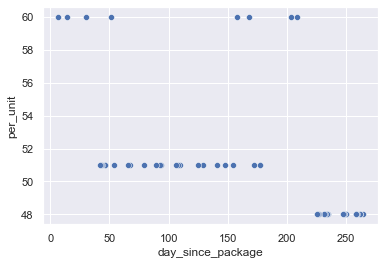

In [49]:
sns.scatterplot(data = product_1, x = 'day_since_package', y = 'per_unit')

In [50]:
lr = LinearRegression()

In [51]:
X = product_1['day_since_package'].values.reshape(-1, 1)
y = product_1['per_unit']
lr.fit(X, y)

LinearRegression()

In [52]:
x_plot = np.linspace(10, 80, 100)

In [53]:
y_plot = lr.predict(x_plot.reshape(-1, 1))

<AxesSubplot:xlabel='day_since_package', ylabel='per_unit'>

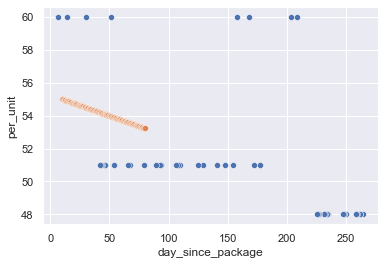

In [54]:
sns.scatterplot(data = product_1, x = 'day_since_package', y = 'per_unit')
sns.scatterplot(x = x_plot, y = y_plot)

<AxesSubplot:xlabel='day_since_package', ylabel='per_unit'>

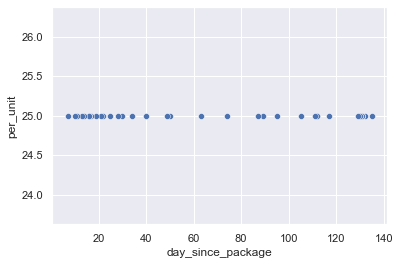

In [55]:
product_2 = df_sales_inventory_by_package[df_sales_inventory_by_package.tx_product_name == 'Hush - Infused Pre Roll - Sunday Driver X GSC - 1.6g']
product_2.sales_datetime = pd.to_datetime(product_2.sales_datetime)
product_2.packaged_date = pd.to_datetime(product_2.packaged_date)
product_2['day_since_package'] = (product_2.sales_datetime.dt.date - product_2.packaged_date.dt.date).dt.days
product_2 = product_2[product_2.day_since_package > 0]
sns.scatterplot(data = product_2, x = 'day_since_package', y = 'per_unit')

<AxesSubplot:xlabel='day_since_package', ylabel='per_unit'>

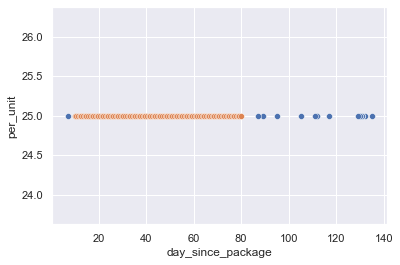

In [56]:
X = product_2['day_since_package'].values.reshape(-1, 1)
y = product_2['per_unit']
lr.fit(X, y)
x_plot = np.linspace(10, 80, 100)
y_plot = lr.predict(x_plot.reshape(-1, 1))
sns.scatterplot(data = product_2, x = 'day_since_package', y = 'per_unit')
sns.scatterplot(x = x_plot, y = y_plot)

In [57]:
def run_regression_price_vs_time_since_package(product_name):
    product_df = df_sales_inventory_by_package[df_sales_inventory_by_package.tx_product_name == product_name]
    product_df.sales_datetime = pd.to_datetime(product_df.sales_datetime)
    product_df.packaged_date = pd.to_datetime(product_df.packaged_date)
    product_df['day_since_package'] = (product_df.sales_datetime.dt.date - product_df.packaged_date.dt.date).dt.days
    product_df = product_df[product_df.day_since_package > 0]
    #sns.scatterplot(data = product_df, x = 'day_since_package', y = 'per_unit')
    X = product_df['day_since_package'].values.reshape(-1, 1)
    y = product_df['per_unit']
    lr.fit(X, y)
    x_plot = np.linspace(10, 80, 100)
    y_plot = lr.predict(x_plot.reshape(-1, 1))
    sns.scatterplot(data = product_df, x = 'day_since_package', y = 'per_unit')
    sns.scatterplot(x = x_plot, y = y_plot)

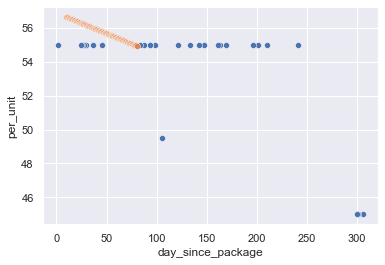

In [58]:
run_regression_price_vs_time_since_package('3.5g - Pure Kush')

# Query development

In [59]:
#you can also query like this
pd.read_sql_query("""SELECT
*
FROM
  `bespoke-financial`.ProdMetrcData.metrc_packages AS metrc_packages
  INNER JOIN `bespoke-financial`.ProdMetrcData.companies AS companies ON metrc_packages.company_id = companies.id
  LEFT JOIN `bespoke-financial`.ProdMetrcData.metrc_transfer_packages AS metrc_transfer_packages ON metrc_packages.package_id = metrc_transfer_packages.package_id
WHERE
  TRUE
  AND LOWER(companies.name) NOT LIKE '%demo%'
  AND companies.identifier = 'EMA'
  AND metrc_packages.type = 'active'
  AND metrc_transfer_packages.shipped_quantity > 0""",engine)

,id,type,company_id,package_id,package_label,package_type,product_name,product_category_name,package_payload,last_modified_at,packaged_date,updated_at,created_at,quantity,unit_of_measure,license_number,us_state,__hevo__ingested_at,__hevo__loaded_at,id_1,name,employer_identification_number,address,country,state,city,zip_code,created_at_1,updated_at_1,dba_name,phone_number,company_settings_id,contract_id,identifier,latest_loan_identifier,needs_balance_recomputed,contract_name,latest_disbursement_identifier,latest_repayment_identifier,is_cannabis,is_customer,is_vendor,is_payor,__hevo__ingested_at_1,__hevo__loaded_at_1,debt_facility_status,parent_company_id,debt_facility_waiver_date,debt_facility_waiver_expiration_date,id_2,package_id_1,transfer_row_id,delivery_id,package_label_1,package_type_1,product_name_1,package_payload_1,lab_results_status,created_at_2,updated_at_2,product_category_name_1,shipper_wholesale_price,shipped_quantity,delivery_row_id,type_1,company_id_1,shipment_package_state,received_quantity,shipped_unit_of_measure,received_unit_of_measure,last_modified_at_1,created_date,license_number_1,us_state_1,__hevo__ingested_at_2,__hevo__loaded_at_2
0,0472a837-808b-4d83-a4e1-c3e9b08f4a59,active,bc8d06ac-e6a4-406a-afb7-c4c0d8481522,13846913,1A4060300006D0A000418178,Product,14296 Kikoko HoneyShot Single Snooze 1:1 CBN 2...,Edible (weight - each),"{'id': 13846913, 'label': '1A4060300006D0A0004...",2021-07-10 03:13:10+00:00,2021-04-30,2021-10-11 05:14:06.005000+00:00,2021-10-03 00:09:53.554000+00:00,5.0,Each,C10-0000774-LIC,CA,1633930182248,1633930545027,bc8d06ac-e6a4-406a-afb7-c4c0d8481522,Embarc Alameda,None,None,None,None,None,None,2021-10-01 21:55:29.588000+00:00,2022-04-25 23:17:32.669000+00:00,None,None,439f761d-13a8-4a90-9d2e-0c083322e0fe,9e126891-da80-4998-85bd-3911e45002e5,EMA,81,False,Alameda Patients Group LLC,46,10,None,True,None,None,1650929230671,1650929744212,ineligible_for_facility,fa0ee1b4-dde7-4b1b-be90-9bcab0d9af32,None,None,d4a329cf-f416-4783-987f-1827509ac751,13846913,3f04faa5-eb87-40d2-aba4-cf5e90b12340,1883924,1A4060300006D0A000418178,Product,14296 Kikoko HoneyShot Single Snooze 1:1 CBN 2...,"{'packageid': 13846913, 'packagelabel': '1A406...",passed,2021-10-02 17:18:45.996000+00:00,2021-10-12 23:30:21.856000+00:00,Edible (weight - each),75.00,25.0,afb18797-5e2f-454c-a401-f3a7dffd84f1,transfer,None,Returned,NaN,Each,None,2021-05-04 16:29:03+00:00,2021-04-30,None,CA,1634081610049,1634082043589
1,c429be43-d074-498f-9b44-c43786392f6d,active,bc8d06ac-e6a4-406a-afb7-c4c0d8481522,10948452,1A40603000050E0000002225,Product,THC- 5ML,Tincture (volume - each),"{'id': 10948452, 'label': '1A40603000050E00000...",2021-01-26 23:07:10+00:00,2021-01-20,2021-10-11 03:36:40.008000+00:00,2021-10-02 09:51:58.793000+00:00,2.0,Each,C10-0000774-LIC,CA,1633923568504,1633923945807,bc8d06ac-e6a4-406a-afb7-c4c0d8481522,Embarc Alameda,None,None,None,None,None,None,2021-10-01 21:55:29.588000+00:00,2022-04-25 23:17:32.669000+00:00,None,None,439f761d-13a8-4a90-9d2e-0c083322e0fe,9e126891-da80-4998-85bd-3911e45002e5,EMA,81,False,Alameda Patients Group LLC,46,10,None,True,None,None,1650929230671,1650929744212,ineligible_for_facility,fa0ee1b4-dde7-4b1b-be90-9bcab0d9af32,None,None,753e55da-c2c7-44a9-90e6-81eefd4b7376,10948452,e10bd236-de02-498c-bfe0-881dda2da435,1479853,1A40603000050E0000002225,Product,THC- 5ML,"{'packageid': 10948452, 'packagelabel': '1A406...",passed,2021-10-02 09:52:48.545000+00:00,2021-10-11 20:54:52.755000+00:00,Tincture (volume - each),0.01,2.0,c0cd0b6b-2901-4eaa-8618-628f24ce04c6,transfer,None,Accepted,2.0,Each,Each,2021-01-26 23:07:10+00:00,2021-01-20,None,CA,1633986280294,1633986950302
2,ba96d740-6014-4f1e-bd4c-f8408ecd6e34,active,bc8d06ac-e6a4-406a-afb7-c4c0d8481522,10978986,1A406030000601A000169171,Product,CBD Refresh Drops 2:1 (15ml),Tincture (volume - each),"{'id': 10978986, 'label': '1A406030000601A0001...",2021-01-26 00:34:12+00:00,2021-01-21,2021-10-11 03:36:40.008000+00:00,2021-10-02 09:49:07.401000+00:00,1

In [60]:
inventory_query = create_queries.create_company_inventory_packages_query(
    ['EL'],
    include_quantity_zero=True,
    license_numbers=['C9-0000370-LIC'],
    )

In [61]:
inventory_query = '''
    SELECT
        metrc_packages.license_number,
        metrc_packages.package_id,
        metrc_packages.package_label,
        metrc_packages.type,
        metrc_packages.packaged_date,
        metrc_packages.last_modified_at,
        metrc_packages.package_type,
        metrc_packages.product_name,
        metrc_packages.product_category_name,
        metrc_packages.quantity,
        metrc_packages.unit_of_measure,
        metrc_packages.package_payload.itemid as item_id,
        metrc_packages.package_payload.itemproductcategorytype as item_product_category_type,
        metrc_packages.package_payload.productionbatchnumber as production_batch_number,
        metrc_packages.package_payload.sourceproductionbatchnumbers as source_production_batch_numbers,
        metrc_packages.package_payload.sourceharvestnames as source_harvest_names,
        metrc_packages.package_payload.istestingsample as is_testing_sample,
        metrc_packages.package_payload.istradesample as is_trade_sample,
        metrc_packages.package_payload.isonhold as is_on_hold,
        metrc_packages.package_payload.archiveddate as archived_date,
        metrc_packages.package_payload.finisheddate as finished_date
    FROM
        companies
    INNER JOIN 
        metrc_packages 
    ON 
        companies.id = metrc_packages.company_id
    WHERE
        True
        AND 
        companies.identifier in ("EL")
        AND 
        (
            metrc_packages.type = 'active' or
            metrc_packages.type = 'onhold'
        )
        AND 
        metrc_packages.license_number in ('C9-0000370-LIC')
    ORDER BY
        metrc_packages.packaged_date desc
'''

In [62]:
pd.read_sql_query(inventory_query, engine)

,license_number,package_id,package_label,type,packaged_date,last_modified_at,package_type,product_name,product_category_name,quantity,unit_of_measure,item_id,item_product_category_type,production_batch_number,source_production_batch_numbers,source_harvest_names,is_testing_sample,is_trade_sample,is_on_hold,archived_date,finished_date
0,C9-0000370-LIC,23614636,1A406030003BD6D000029662,active,2022-03-28,2022-04-27 11:18:25+00:00,Product,Almora Farm: 3.5g Flower: Blue Banana [H],Flower (packaged eighth - each),74.0,Each,4090273,Buds,,E5000332131PB,"BLB-10/23/21-BS-5601, BLB-10/23/21-BS-5601 (2)...",False,False,False,None,None
1,C9-0000370-LIC,23614629,1A406030003BD6D000029660,active,2022-03-28,2022-03-30 23:39:05+00:00,Product,Almora Farm: 28g Flower: Legend OG [I],Flower (packaged ounce - each),8.0,Each,4090080,Buds,,E5000332029PB,"Legend OG 11-02-2021 2820, LO-11/10/21-BN-5505...",False,False,False,None,None
2,C9-0000370-LIC,23614649,1A406030003BD6D000029672,active,2022-03-28,2022-04-18 11:18:26+00:00,Product,Surplus Tropics: 1g Cart: Pina Colada [H],Vape Cartridge (volume - each),19.0,Each,4094912,Concentrate,,F6000014740PB,"5-14-2021 Purple Punch Zone 11, 5-27-21 Purple...",False,False,False,None,None
3,C9-0000370-LIC,23614652,1A406030003BD6D000029674,active,2022-03-28,2022-04-26 11:18:57+00:00,Product,Surplus Purified Live Resin: 1g Cart: GG4 [H],Vape Cartridge (volume - each),16.0,Each,4094386,Concentrate,,F6000011211PB,"0103SundaeDriver090219A, 0103SundaeDriver09021...",False,False,False,None,None
4,C9-0000370-LIC,23614640,1A406030003BD6D000029667,active,2022-03-28,2022-03-30 23:39:05+00:00,Product,Surplus Tropics: 1g Cart: Grape Crush [I],Vape Cartridge (volume - each),25.0,Each,4094909,Concentrate,,F6000015505PB,"Banana Punch - A-08-20-2021-0008, Chem Driver ...",False,False,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,C9-0000370-LIC,7628133,1A4060300006E2E000042535,active,2020-09-01,2020-09-12 22:58:06+00:00,Product,KE - THC NANO Vegan Blood Orange Bliss Indica ...,Edible (weight - each),0.0,Each,383492,InfusedEdible,,,"AC - UA11, Banana Cream - 1032-C 6/16/20 #68, ...",False,False,False,None,None
213,C9-0000370-LIC,7628249,1A4060300006E2E000042528,active,2020-09-01,2020-09-12 22:58:06+00:00,Product,KE - CBD Tranquility 1:1:1,Edible (weight - each),0.0,Each,1756222,InfusedEdible,,,"Banana Cream - 937.1-A 2/7/20 #30, Banana Crea...",False,False,False,None,None
214,C9-0000370-LIC,7628330,1A4060300006E2E000042532,active,2020-09-01,2020-09-12 22:58:06+00:00,Product,KE - THC Indica Mango 100mg - 43g,Edible (weight - each),0.0,Each,383485,InfusedEdible,,,"1st, 2019-10-18-2-H, 2019-10-18-3-H, 2019-10-1...",False,False,False,None,None
215,C9-0000370-LIC,7628134,1A4060300006E2E000042536,active,2020-09-01,2020-09-12 22:58:06+00:00,Product,KE - THC Sativa Ruby Grapefruit 100mg - 43g,Edible (weight - each),0.0,Each,383497,InfusedEdible,,,"1st, 2019-10-18-2-H, 2019-10-18-3-H, 2019-10-1...",False,False,False,None,None


In [63]:
query_sales = create_queries.create_company_sales_receipts_with_transactions_query(
    ['EL'],
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=['C9-0000370-LIC'],
)
print(query_sales)


		select
			metrc_sales_receipts.license_number,
			metrc_sales_receipts.receipt_number,
			metrc_sales_receipts.type as rt_type,
			metrc_sales_receipts.sales_customer_type,
			metrc_sales_receipts.sales_datetime,
			date_trunc(metrc_sales_receipts.sales_datetime, month) as sales_month,
			metrc_sales_receipts.total_packages,
			metrc_sales_receipts.total_price as rt_total_price,
			metrc_sales_transactions.type as tx_type,
			metrc_sales_transactions.package_id as tx_package_id,
			metrc_sales_transactions.package_label as tx_package_label,
			metrc_sales_transactions.product_name as tx_product_name,
			metrc_sales_transactions.product_category_name as tx_product_category_name,
			metrc_sales_transactions.unit_of_measure as tx_unit_of_measure,
			metrc_sales_transactions.quantity_sold as tx_quantity_sold,
			metrc_sales_transactions.total_price as tx_total_price
		from
			metrc_sales_receipts
			inner join companies on metrc_sales_receipts.company_id = companies.id
			left outer joi

In [64]:
query_incoming = create_queries.create_company_incoming_transfer_packages_query(
    ['EL'],
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=['C9-0000370-LIC'],
    )
print(query_incoming)


		select
			case
				when company_deliveries.delivery_type = 'INCOMING_UNKNOWN' then 'INCOMING_FROM_VENDOR'
				when company_deliveries.delivery_type = 'INCOMING_FROM_VENDOR' then 'INCOMING_FROM_VENDOR'
				when company_deliveries.delivery_type = 'OUTGOING_UNKNOWN' then 'OUTGOING_TO_PAYOR'
				when company_deliveries.delivery_type = 'OUTGOING_TO_PAYOR' then 'OUTGOING_TO_PAYOR'
				else company_deliveries.delivery_type
			end as delivery_type,
			company_deliveries.license_number,
			metrc_transfers.manifest_number,
			metrc_transfers.created_date,
			metrc_deliveries.received_datetime,
			metrc_transfers.transfer_payload.shipmenttransactiontype as shipment_transaction_type,
			metrc_transfers.shipper_facility_license_number,
			metrc_transfers.shipper_facility_name,
			metrc_deliveries.recipient_facility_license_number,
			metrc_deliveries.recipient_facility_name,
			metrc_deliveries.shipment_type_name,
			metrc_deliveries.shipment_transaction_type,
			metrc_transfer_packages.package_

In [65]:
def create_inventory_days_since_package_metric_query(COMPANY_IDENTIFIER,license_numbers, include_quantity_zero, sales_transactions_start_date):
    inventory_query = create_queries.create_company_inventory_packages_query(
        COMPANY_IDENTIFIER,
        include_quantity_zero=True,
        license_numbers=license_numbers,
    )
    query_sales = create_queries.create_company_sales_receipts_with_transactions_query(
        COMPANY_IDENTIFIER,
        sales_transactions_start_date,
        license_numbers=license_numbers,
    )
    days_sold_since_package_metric_query = '''
        SELECT 
            sales.license_number,
            sales.receipt_number,
            sales.rt_type,
            sales.sales_customer_type,
            sales.sales_datetime,
            sales.sales_month,
            sales.total_packages,
            sales.rt_total_price,
            sales.tx_type,
            sales.tx_package_id,
            sales.tx_package_label,
            sales.tx_product_name,
            sales.tx_product_category_name,
            sales.tx_unit_of_measure,
            sales.tx_quantity_sold,
            sales.tx_total_price,
            inventory.package_id,
            inventory.package_label,
            inventory.type,
            inventory.packaged_date,
            inventory.last_modified_at,
            inventory.package_type,
            inventory.product_name,
            inventory.product_category_name,
            inventory.quantity,
            inventory.unit_of_measure,
            inventory.item_id,
            inventory.item_product_category_type,
            inventory.production_batch_number,
            inventory.source_production_batch_numbers,
            inventory.source_harvest_names,
            inventory.is_testing_sample,
            inventory.is_trade_sample,
            inventory.is_on_hold,
            inventory.archived_date,
            inventory.finished_date,
            DATE_DIFF(DATE(sales.sales_datetime), DATE(inventory.packaged_date), DAY) AS days_diff
        FROM 
            ({QUERY_SALES}) AS sales
        INNER JOIN
            ({QUERY_INVENTORY}) AS inventory
        ON 
            sales.tx_package_id = inventory.package_id 
        ORDER BY packaged_date DESC
    '''
    days_sold_since_package_metric_query = days_sold_since_package_metric_query.format(QUERY_SALES=query_sales,
                                                                                       QUERY_INVENTORY=inventory_query)
    return days_sold_since_package_metric_query

In [66]:
query_join = create_inventory_days_since_package_metric_query(['EL'], ['C9-0000370-LIC'], True, SALES_TRANSACTIONS_START_DATE)
print(query_join)


        SELECT 
            sales.license_number,
            sales.receipt_number,
            sales.rt_type,
            sales.sales_customer_type,
            sales.sales_datetime,
            sales.sales_month,
            sales.total_packages,
            sales.rt_total_price,
            sales.tx_type,
            sales.tx_package_id,
            sales.tx_package_label,
            sales.tx_product_name,
            sales.tx_product_category_name,
            sales.tx_unit_of_measure,
            sales.tx_quantity_sold,
            sales.tx_total_price,
            inventory.package_id,
            inventory.package_label,
            inventory.type,
            inventory.packaged_date,
            inventory.last_modified_at,
            inventory.package_type,
            inventory.product_name,
            inventory.product_category_name,
            inventory.quantity,
            inventory.unit_of_measure,
            inventory.item_id,
            inventory.item_product_cat

In [67]:
def create_company_freshness_metric_query(COMPANY_IDENTIFIER, license_numbers, include_quantity_zero, sales_transactions_start_date, groupby_col):
    days_sold_query = create_inventory_days_since_package_metric_query(COMPANY_IDENTIFIER,license_numbers, include_quantity_zero, sales_transactions_start_date)
    freshness_metric_query = '''
        SELECT 
            {GROUPBY_COL},
            AVG(CASE WHEN days_diff > 0 THEN days_diff ELSE 0 END) AS avg_days_since_sale,
            MAX(CASE WHEN days_diff > 0 THEN days_diff ELSE 0 END) AS max_days_since_sale,
            MIN(CASE WHEN days_diff > 0 THEN days_diff ELSE 0 END) AS min_days_since_sale,
            COUNT({GROUPBY_COL}) AS number_of_sales
        FROM 
            ({DAYS_SOLD_QUERY}) AS days_sold
        GROUP BY 
            {GROUPBY_COL}
    '''
    freshness_metric_query = freshness_metric_query.format(GROUPBY_COL=groupby_col, DAYS_SOLD_QUERY=days_sold_query)
    return freshness_metric_query

In [68]:
query_metric = create_company_freshness_metric_query(['EL'], ['C9-0000370-LIC'], True, SALES_TRANSACTIONS_START_DATE, 'tx_product_category_name')
print(query_metric)


        SELECT 
            tx_product_category_name,
            AVG(CASE WHEN days_diff > 0 THEN days_diff ELSE 0 END) AS avg_days_since_sale,
            MAX(CASE WHEN days_diff > 0 THEN days_diff ELSE 0 END) AS max_days_since_sale,
            MIN(CASE WHEN days_diff > 0 THEN days_diff ELSE 0 END) AS min_days_since_sale,
            COUNT(tx_product_category_name) AS number_of_sales
        FROM 
            (
        SELECT 
            sales.license_number,
            sales.receipt_number,
            sales.rt_type,
            sales.sales_customer_type,
            sales.sales_datetime,
            sales.sales_month,
            sales.total_packages,
            sales.rt_total_price,
            sales.tx_type,
            sales.tx_package_id,
            sales.tx_package_label,
            sales.tx_product_name,
            sales.tx_product_category_name,
            sales.tx_unit_of_measure,
            sales.tx_quantity_sold,
            sales.tx_total_price,
            inv

In [69]:
pd.read_sql_query(query_metric, engine)

,tx_product_category_name,avg_days_since_sale,max_days_since_sale,min_days_since_sale,number_of_sales
0,Pre-Roll Flower,101.199234,264,5,261
1,Flower (packaged ounce - each),77.235294,137,12,17
2,Topical (volume - each),101.437500,185,11,16
3,Pre-Roll Infused,50.601266,135,4,158
4,Flower (packaged gram - each),41.781250,84,8,32
5,Flower (packaged quarter - each),58.514706,114,5,68
6,Vape Cartridge (weight - each),72.726496,167,1,117
7,Edible (volume - each),3.000000,4,2,2
8,Other Concentrate (weight - each),119.292683,434,4,41
9,Edible (weight - each),99.924528,548,2,530


In [70]:
query_metric_product_name = create_company_freshness_metric_query(['EL'], ['C9-0000370-LIC'], True, SALES_TRANSACTIONS_START_DATE, 'tx_product_name')
pd.read_sql_query(query_metric_product_name, engine)

,tx_product_name,avg_days_since_sale,max_days_since_sale,min_days_since_sale,number_of_sales
0,Highrize - Octane Kush Premium Flower 12pk Tins,43.333333,70,16,12
1,Surplus Purified Live Resin: 1g Cart: Pineappl...,12.875000,22,3,8
2,"All-in-One CDT Three Blue Kings .5g Vape (H), ...",97.800000,131,53,5
3,Fiori Friend CBD Pet Supplement (300mg CBD),385.750000,512,76,8
4,Camino Gummies 75 Wild Cherry - 100mg,70.000000,106,9,11
...,...,...,...,...,...
143,KE - CBD Peach 4:1 - 43g,34.500000,64,9,6
144,FloraCal Sunset Sherb (1g) Preroll,36.238095,66,19,21
145,Surplus Purified Live Resin: 1g Cart: Skywalke...,14.500000,25,2,6
146,Highrize - Royal Ringo Premium Flower 12 pack ...,32.500000,43,22,2


In [71]:
query_metric_product = create_company_freshness_metric_query(['EL', '99HT'], ['C9-0000370-LIC', 'C10-0000279-LIC'], True, SALES_TRANSACTIONS_START_DATE, 'tx_product_category_name')
pd.read_sql_query(query_metric_product, engine)

,tx_product_category_name,avg_days_since_sale,max_days_since_sale,min_days_since_sale,number_of_sales
0,Other Concentrate (volume - each),33.793103,55,4,29
1,Topical (volume - each),96.375000,432,4,176
2,Pre-Roll Leaf,40.309565,236,1,575
3,Tincture (weight - each),11.000000,13,7,8
4,Shake (Packaged Gram - each),14.762712,44,2,59
5,Flower (packaged ounce - each),77.235294,137,12,17
6,Flower (packaged - each),40.407484,306,1,481
7,Topical (weight - each),89.150000,401,0,160
8,Tincture (volume - each),113.728625,512,1,538
9,Other Concentrate (weight - each),103.322430,434,4,214
